In [57]:
#This notebook reproduces analyses and graphs for Table 1, Figures 3a-d and 4a-f from "A data compendium of Mycobacteriumtuberculosis antibiotic resistance" 

#ENTER LOCAL FILE PATH TO CRYPTIC TABLES
file_path='../example/file/path'

# Common imports
import pandas as pd
import numpy as np
import os
import os.path
from collections import Counter
import itertools
import statsmodels
from statsmodels.stats.proportion import proportions_ztest


# To plot figures
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import geopandas
import seaborn as sns
%matplotlib inline

In [58]:
def z_test(sample_success_a, sample_size_a, sample_success_b, sample_size_b):
    '''runs two tailed z test to compare two percentages. 
    Input = positive samples from A, sample size A, positivie samples from B, sample size B'''
    
    significance = 0.05


    successes = np.array([sample_success_a, sample_success_b])
    samples = np.array([sample_size_a, sample_size_b])

    stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
    # report
    print('z_stat: %0.5f, p_value: %0.5f' % (stat, p_value))
    if p_value > significance:
        print ("Fail to reject the null hypothesis - we have nothing else to say")
    else:
        print ("Reject the null hypothesis - suggest the alternative hypothesis is true")

In [59]:
#read in isolates with WGS data, file contains lineage information
genomes = pd.read_pickle(file_path+"/GENOMES.pkl.gz")
genomes.reset_index(level=0, inplace=True)
genomes=genomes.loc[(genomes.BELONGS_GPI==True)&(genomes.SITEID!='QC') ]
print('Total isolates =', genomes.UNIQUEID.nunique())

Total isolates = 15211


In [60]:
#read in sample information and table to interpret country codes
countries = pd.read_csv(file_path+"/COUNTRIES_LOOKUP.csv")
samples = pd.read_pickle(file_path+"/SAMPLES.pkl.gz")
samples.reset_index(level=2, inplace=True)
samples.reset_index(level=1, inplace=True)
samples.reset_index(level=0, inplace=True)
print(samples.COUNTRY_WHERE_SAMPLE_TAKEN.nunique(),'countries in total')
country_list=[]
for i in samples.COUNTRY_WHERE_SAMPLE_TAKEN.unique():
    country_list.append(i)
print(country_list)


27 countries in total
['CHN', 'PER', 'VNM', 'GBR', 'SWE', 'BRA', 'ZAF', 'IND', 'TWN', 'AFG', 'NPL', 'DEU', 'TKM', 'KGZ', 'TJK', 'AUS', 'KAZ', 'UKR', 'JPN', 'DZA', 'ITA', 'SOM', 'PAK', 'BFA', 'ALB', 'TUN', 'NGA']


In [61]:
#read in phenotypes (MIC) data
phenotypes = pd.read_pickle(file_path+"/UKMYC_PHENOTYPES.pkl.gz")
phenotypes.reset_index(level=1, inplace=True)
phenotypes.reset_index(level=0, inplace=True)

phenotypes=phenotypes.loc[(phenotypes.BELONGS_GPI == True)
                          &(phenotypes.PHENOTYPE_QUALITY.isin(['HIGH','MEDIUM','LOW']))
                          &(phenotypes.DILUTION >=0)
                          &(phenotypes.DRUG!='PAS')
                          &(phenotypes.BINARY_PHENOTYPE.notna())]
print('number of isolates with phenotypes to 1+ drugs =',phenotypes.UNIQUEID.nunique())
print('number of MIC readings =',len(phenotypes))

#assign R/S to INH/ETH/EMB isolates using ECOFFs from The CRyPTIC Consortium, European Respiratory Journal 2022; DOI: 10.1183/13993003.00239-2022
phenotypes.loc[((phenotypes['DRUG'] =='INH')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'R'
phenotypes.loc[((phenotypes['DRUG'] =='ETH')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'S'
phenotypes.loc[((phenotypes['DRUG'] =='EMB')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'S'

number of isolates with phenotypes to 1+ drugs = 12289
number of MIC readings = 157401


In [62]:
#merge sample uniqueids and country information
gs = pd.merge(genomes, samples, how='left', on=['SITEID','SUBJID','LABID'])
gs.UNIQUEID.nunique()
#merge with phenotypes
gps = pd.merge(gs,phenotypes, how='left', on=['UNIQUEID'])

In [63]:
#make dataframe of isolate MIC quality for each drug
drug_names_list=['INH','RIF','EMB','LEV','MXF','AMI','KAN',
                 'BDQ','CFZ','DLM','LZD','ETH','RFB']
n_list=[]
hq_list=[]
mq_list=[]
lq_list=[]
fail_list=[]
for i in drug_names_list:
    n=len(phenotypes[(phenotypes.DRUG==i)])-len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE.isna())])
    n_list.append(n)
    hq=len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.PHENOTYPE_QUALITY=='HIGH')])-len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE.isna())])
    hq_list.append(hq)
    mq=len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.PHENOTYPE_QUALITY=='MEDIUM')])-len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE.isna())])
    mq_list.append(mq)
    lq=len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.PHENOTYPE_QUALITY=='LOW')])-len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE.isna())])
    lq_list.append(lq)

quality_df=pd.DataFrame(list(zip(drug_names_list,n_list,hq_list,mq_list,lq_list)), 
                 columns=['DRUG','PHENOTYPES','HIGH_QUALITY','MEDIUM_QUALITY','LOW_QUALITY'])
quality_df.to_csv('phenotype_quality_per_drug.csv')
quality_df

,DRUG,PHENOTYPES,HIGH_QUALITY,MEDIUM_QUALITY,LOW_QUALITY
0,INH,12070,9519,1351,1200
1,RIF,12099,8955,1356,1788
2,EMB,12158,7506,1355,3297
3,LEV,12163,7774,1354,3035
4,MXF,12194,6785,1353,4056
5,AMI,12072,8973,1350,1749
6,KAN,12130,9333,1355,1442
7,BDQ,12068,8536,1355,2177
8,CFZ,12049,7763,1352,2934
9,DLM,11927,8095,1349,2483


   DRUG  PHENOTYPES      S     R         %S         %R
0   INH       12070   6161  5909  51.043911  48.956089
1   RIF       12099   7414  4685  61.277792  38.722208
2   EMB       12158   9897  2261  81.403191  18.596809
3   LEV       12163  10017  2146  82.356327  17.643673
4   MXF       12194  10470  1724  85.861899  14.138101
5   AMI       12072  11189   883  92.685553   7.314447
6   KAN       12130  11009  1121  90.758450   9.241550
7   BDQ       12068  11959   109  99.096785   0.903215
8   CFZ       12049  11524   525  95.642792   4.357208
9   DLM       11927  11741   186  98.440513   1.559487
10  LZD       12189  12033   156  98.720158   1.279842
11  ETH       12132  10405  1727  85.764919  14.235081
12  RFB       12150   7685  4465  63.251029  36.748971


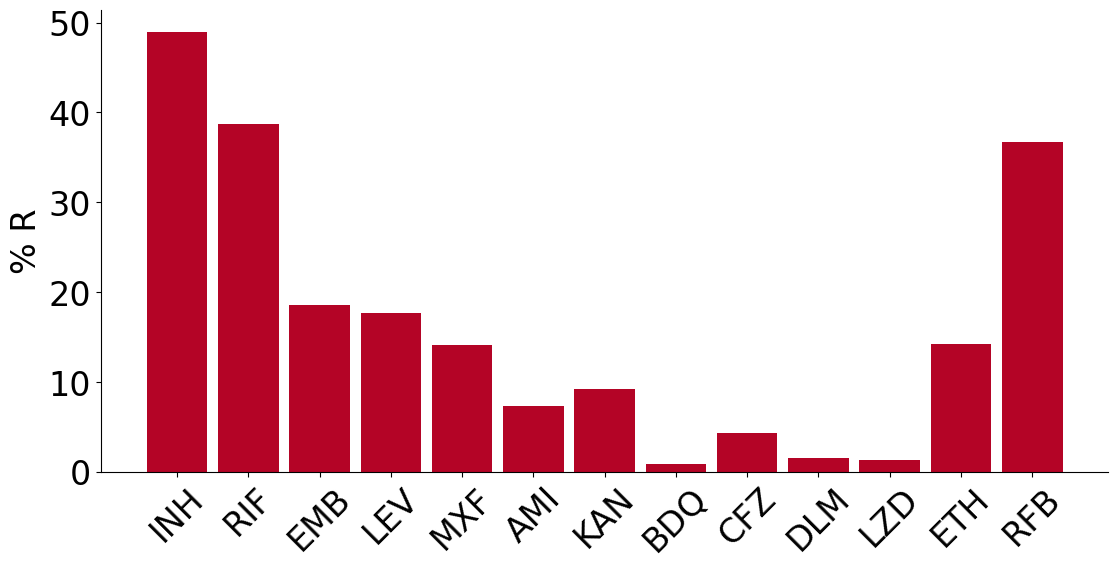

In [64]:
#calculate number of isolates wit a phenotpye to each drug and the proportion that are resistant to each drug
drug_names_list=['INH','RIF','EMB','LEV','MXF','AMI','KAN',
                 'BDQ','CFZ','DLM','LZD','ETH','RFB']
t_list=[]
s_list=[]
r_list=[]
i_list=[]
for i in drug_names_list:
    t=len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE.notna())])
    t_list.append(t)
    s=len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE=='S')])
    s_list.append(s)
    r=len(phenotypes[(phenotypes.DRUG==i)&(phenotypes.BINARY_PHENOTYPE=='R')])
    r_list.append(r)
sr_df=pd.DataFrame(list(zip(drug_names_list,t_list,s_list,r_list)), 
                 columns=['DRUG','PHENOTYPES','S','R'])
sr_df['%S']=sr_df['S']/sr_df['PHENOTYPES']*100
sr_df['%R']=sr_df['R']/sr_df['PHENOTYPES']*100

print(sr_df)

#create graph
SMALL_SIZE = 14
MEDIUM_SIZE = 24
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.figure(figsize=(len(drug_names_list),6))

N = len(drug_names_list)
L1 = sr_df['%R']



ind = np.arange(N)    
width = 0.85       

p1 = plt.bar(ind, L1, width, color= '#b40426')




plt.ylabel('% R')
plt.title('')
plt.xticks(ind, (drug_names_list), rotation=45)


for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False) 


plt.savefig('%R_per_drug.png', dpi=300, transparent=True, bbox_inches='tight')

In [65]:

if os.path.isfile('drugs_df.csv') ==False:
    #create table showing resistance profile to 13 drugs for each isolate (1 = R, 0 = S, Nan = No MIC measurement)
    #takes ~30 minutes
    drugs_df = pd.DataFrame(columns=['UNIQUEID','INH','RIF','EMB', 'LEV','MXF','AMI','KAN',
                 'BDQ','CFZ','DLM','LZD','ETH','RFB'])
    drug_names_list=['INH','RIF','EMB','LEV','MXF','AMI','KAN',
                 'BDQ','CFZ','DLM','LZD', 'ETH','RFB']
    for U in phenotypes.UNIQUEID.unique():
        u_list=[]
        rs=phenotypes[phenotypes.UNIQUEID==U]
        list1=[]
        list1.append(U)
        for drug in drug_names_list:
            if rs.loc[rs['DRUG']==drug].BINARY_PHENOTYPE.values =='R':
                list1.append(1)
            elif rs.loc[rs['DRUG']==drug].BINARY_PHENOTYPE.values =='S':
                list1.append(0)
            else:
                list1.append(np.nan)
        df_length = len(drugs_df)
        drugs_df.loc[df_length] = list1
    drugs_df=drugs_df.set_index(drugs_df['UNIQUEID'], drop=True)
    drugs_df=drugs_df.drop(columns=['UNIQUEID'])
    print(len(drugs_df))
    drugs_df.to_csv('drugs_df.csv')
    


In [66]:
#read resistance profile to 13 drugs for each isolate (1 = R, 0 = S, Nan = No MIC measurement) as dataframe
drugs_df=pd.read_csv('drugs_df.csv', index_col='UNIQUEID')


In [67]:
#find number of isolates with phenotpyes for all 13 drugs
listna=drugs_df.isnull().sum(axis=1).tolist()
print(Counter(listna))
print('Number of isolates with phenotypes for all drugs =', Counter(listna)[0])

Counter({0: 10821, 1: 1030, 2: 237, 3: 91, 4: 49, 5: 25, 6: 17, 7: 10, 9: 3, 11: 3, 8: 2, 10: 1})
Number of isolates with phenotypes for all drugs = 10821


In [68]:
#are there any isolates resistant to all 13 drugs?
totr_list=drugs_df.loc[drugs_df.sum(1)==13].index.tolist()

df=gs.loc[(gs.UNIQUEID.isin(totr_list))]
u_list=df.UNIQUEID.to_list()
lin_list=df.LINEAGE_NAME.to_list()
country_list=df.COUNTRY_WHERE_SAMPLE_TAKEN.to_list()

allR_df=pd.DataFrame(list(zip(u_list,country_list,lin_list)), 
                 columns=['UNIQUEID','COUNTRY','LINEAGE'])
allR_df.to_csv('totally_resistant_isolates.csv')
allR_df

,UNIQUEID,COUNTRY,LINEAGE
0,site.11.subj.XTB-18-224.lab.XTB-18-224.iso.1,NaN,Lineage 2
1,site.10.subj.YA00026182.lab.YA00026182.iso.1,ZAF,Lineage 4


In [69]:
def R_COUNTS(subset, country):
    '''Creates row in dataframe showing numbers of MDR/XDR etc isolates in a country'''
    no_s=0
    no_mdr_rr=0
    no_pre_xdr=0
    no_xdr=0
    no_other=0
    count=0
    r_count=0
    inh_r=0
    rif_r=0
    randi_s=0

    total_list=[]
    for U in subset.UNIQUEID.unique():
        if U in drugs_df.index.tolist():
            x=drugs_df.loc[U]
            x=x.fillna(0)
            count=count+1
            if ((x.RIF)==1 and (x.LEV+x.MXF)>=1 and (x.BDQ+x.LZD)>=1):
                no_xdr=no_xdr+1
            if (x.RIF==1 and (x.LEV+x.MXF)>=1):
                no_pre_xdr=no_pre_xdr+1
            if ((x.sum()!=0)&(x['INH']+x['RIF']<=1)):
                no_other=no_other+1
            if (x.sum()==0):
                no_s=no_s+1
            if (x.sum()>=1):
                r_count=r_count+1
            if ((x.sum()!=0)&(x['INH']+x['RIF']<=1)&(x['INH']==1)):
                inh_r=inh_r+1
            if ((x.sum()!=0)&(x['INH']+x['RIF']<=1)&(x['RIF']==1)):
                rif_r=rif_r+1
            if (x['RIF']==1):
                no_mdr_rr=no_mdr_rr+1
            if ((x.sum()!=0)&(x['RIF']!=1)&(x['INH']!=1)):
                randi_s=randi_s+1   

    df = pd.DataFrame({
        "COUNTRY":[country],
        "S":[no_s],
        "MDR/RR":[no_mdr_rr],
        "XDR":[no_xdr],
        "PRE_XDR":[(no_pre_xdr-no_xdr)],
        "RIF_R":[rif_r],
        "INH_R":[inh_r],
        "RANDI_S":[randi_s],
        "TOTAL":[count],
        "NO_R":[r_count]
        })
    return df


In [70]:
#calculate number of each phenotype in total dataset
total=R_COUNTS(gps, 'TOTAL')
#calculate number of each phenotype in each country and append to dataframe
for i in gps.COUNTRY_WHERE_SAMPLE_TAKEN.unique():
    total=total.append(R_COUNTS(gps[(gps.COUNTRY_WHERE_SAMPLE_TAKEN==i)],str(i)))
nan=R_COUNTS(gps[(gps.COUNTRY_WHERE_SAMPLE_TAKEN.isnull())|(gps.COUNTRY_WHERE_SAMPLE_TAKEN=='None')],'UNKNOWN')
counts_df=total.append(nan)
counts_df.reset_index(inplace=True)
zero_index=counts_df.loc[counts_df['TOTAL']==0].index
counts_df=counts_df.drop(zero_index)
counts_df=counts_df.sort_values(by='TOTAL', ascending=False)
counts_df

,index,COUNTRY,S,MDR/RR,XDR,PRE_XDR,RIF_R,INH_R,RANDI_S,TOTAL,NO_R
0,0,TOTAL,5475,4685,142,1819,332,1556,573,12289,6814
2,0,PER,1378,853,0,140,58,356,51,2638,1260
25,0,UNKNOWN,921,977,33,373,70,342,129,2369,1448
8,0,ZAF,653,655,49,231,116,242,91,1641,988
9,0,IND,555,770,30,508,19,78,65,1468,913
1,0,CHN,645,276,15,106,13,80,106,1107,462
4,0,VNM,497,114,0,12,8,251,73,935,438
18,0,PAK,51,387,3,186,11,42,9,489,438
12,0,DEU,321,86,7,18,6,32,5,444,123
7,0,BRA,157,83,2,14,11,66,36,342,185


<ipython-input-71-7c9a1d385b5b>:12: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  mypie2, _ = ax.pie([data.RANDI_S[0]/total,data.INH_R[0]/total,
<ipython-input-71-7c9a1d385b5b>:24: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  mypie3, _ = ax.pie([ data.PRE_XDR[0]/total,


[<matplotlib.patches.Wedge object at 0x12bf39ee0>, <matplotlib.patches.Wedge object at 0x12bf392e0>]


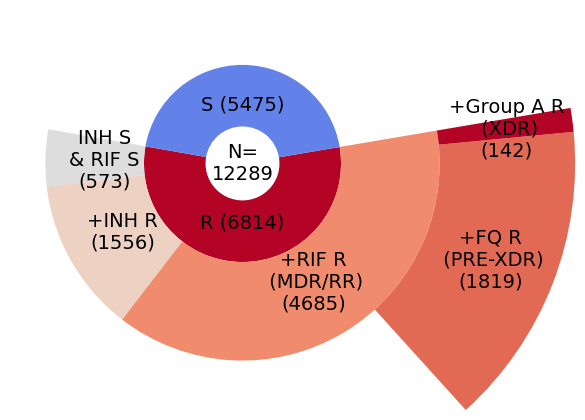

In [71]:
data=counts_df.loc[counts_df.COUNTRY=='TOTAL']
total=data.TOTAL[0]
# First Ring (outside)
fig, ax = plt.subplots(figsize=(6,4))
ax.axis('equal')
mypie, _ = ax.pie([data.NO_R[0]/total,(data.TOTAL[0]-data.NO_R[0])/total], radius=0.8, labels=['R ('+str(data.NO_R[0])+')','S ('+str(data.TOTAL[0]-data.NO_R[0])+')'], 
                  labeldistance=0.6, startangle=170,
                  textprops=dict(color="k",size=14, horizontalalignment="center", verticalalignment='center'),colors=['#b40426', '#6282ea'])
plt.setp( mypie, width=0.5)
 
# Second Ring 
mypie2, _ = ax.pie([data.RANDI_S[0]/total,data.INH_R[0]/total,
                    (data['MDR/RR'][0])/total], radius=0.8+0.8, startangle=170, 
                    labels=['INH S\n& RIF S\n('+str(data.RANDI_S[0])+')',
                            '+INH R\n('+str(data.INH_R[0])+')',
                            '+RIF R\n (MDR/RR)\n('+str(data['MDR/RR'][0])+')'], 
                    labeldistance=0.7, colors=['#dddddd','#edd1c2', '#f08b6d'], rotatelabels=False, 
                    textprops=dict(color="k",size=14, horizontalalignment="center", verticalalignment='center'))
plt.setp( mypie2, width=0.8)
plt.margins(0,0)

#Thrid Ring

mypie3, _ = ax.pie([ data.PRE_XDR[0]/total,
                    (data.XDR[0])/total ], 
                    radius=0.8+1.9, labeldistance=0.8, colors=['#e26953','#b40426'], 
                    rotatelabels=False,  startangle=170+float(((data['MDR/RR'][0]-data.PRE_XDR[0]-data.XDR[0])/total+(data.RANDI_S[0]/total)+(data.INH_R[0]/total))*360),
                    labels=['+FQ R\n (PRE-XDR)\n('+str(data.PRE_XDR[0])+')',
                            '+Group A R\n (XDR)\n('+str(data.XDR[0])+')'], 
                            textprops=dict(color="k",size=14, horizontalalignment="center", verticalalignment='center'))
print(mypie3)
plt.setp( mypie3, width=1.1)
plt.margins(0,0)



plt.text(0,0,"N=\n"+str(len(drugs_df)), horizontalalignment='center', verticalalignment='center', size=14)
plt.savefig('full_dataset_pie.png', dpi=300, transparent=True, bbox_inches='tight')


In [72]:
#print phenotype percentages
data=counts_df.loc[counts_df.COUNTRY=='TOTAL']
print("%R =",data.NO_R[0]/data.TOTAL[0]*100)
print("% of R isolates that are MDR/RR =",(data['MDR/RR'][0])/(data.NO_R[0])*100)
print('% of MDR isolates that are XDR =', (data.XDR[0])/(data['MDR/RR'][0])*100)
print('% of MDR isolates that are PRE_XDR =', (data.PRE_XDR[0])/(data['MDR/RR'][0])*100)


%R = 55.44796159166735
% of R isolates that are MDR/RR = 68.75550337540358
% of MDR isolates that are XDR = 3.030949839914621
% of MDR isolates that are PRE_XDR = 38.826040554962646


In [73]:
#create world df for % of isoaltes that are S from each country contribution
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
tb_world=pd.merge(world, counts_df, left_on='iso_a3', right_on='COUNTRY', how='left')
#tb_world = tb_world[(world.name!="Antarctica")]
tb_world['%R']=(tb_world['TOTAL']-tb_world['S'])/tb_world['TOTAL']*100
tb_world['%S']=tb_world['S']/tb_world['TOTAL']*100
#create world df for proportions of R phenotypes seen in countries with >99 R isolates
tb_world_r=tb_world.loc[(tb_world['NO_R'])>=100]
tb_world_r=pd.merge(tb_world_r,countries, how='left', left_on='COUNTRY', right_on='COUNTRY_CODE_3_LETTER')
lat=tb_world_r.LAT
long=tb_world_r.LONG
#pick out R categories for pie charts
r1=tb_world_r.RANDI_S
r2=tb_world_r.INH_R
r4=(tb_world_r['MDR/RR'] - tb_world_r.PRE_XDR - tb_world_r.XDR)
r5=tb_world_r.PRE_XDR
r7=tb_world_r.XDR
tot=tb_world_r['NO_R']

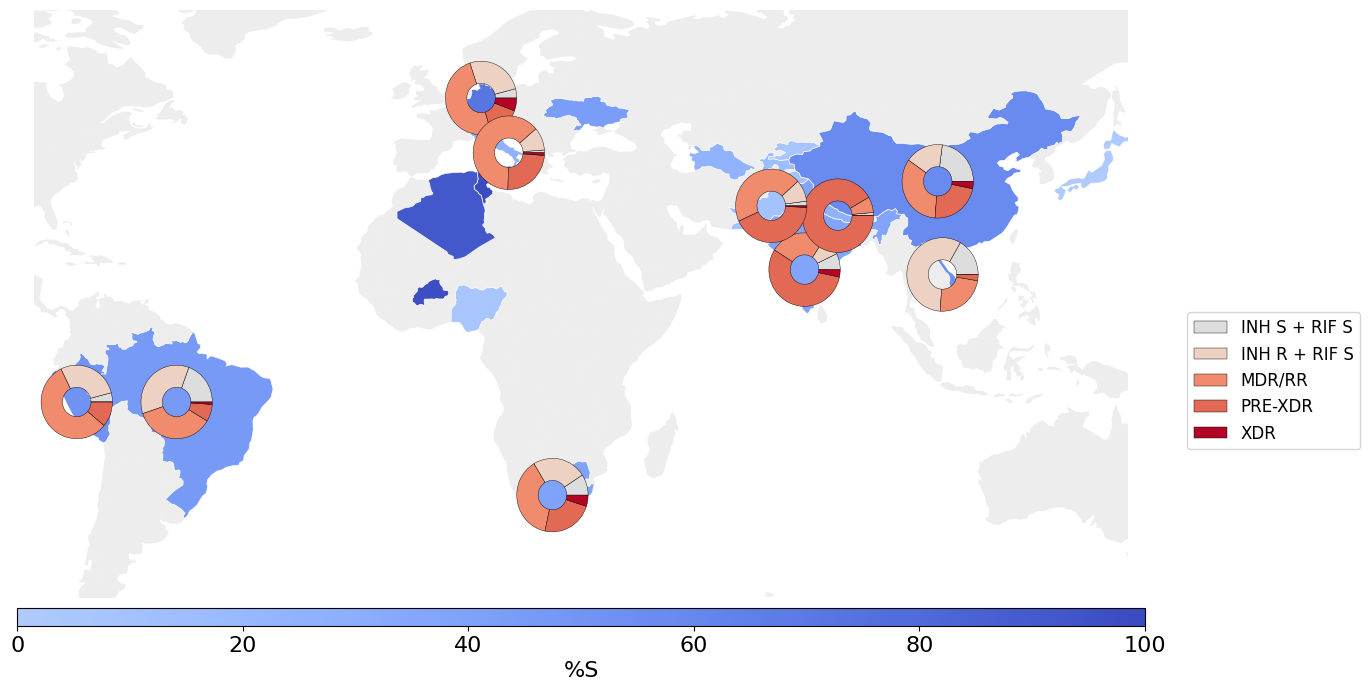

In [74]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''make truncated colormap from given plt cmap, provide section of colormap to use my giving min and max values between 0 and 1'''
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('coolwarm_r')
new_cmap = truncate_colormap(cmap, 0.65, 1)

#make world map Resistance phenotpye pies
fig, ax = plt.subplots(1, 1,figsize=(15,8))
for i in range(len(tb_world_r)):
    if tb_world_r.COUNTRY[i]=='DEU':
        center=(long[i],lat[i]+1)
    elif tb_world_r.COUNTRY[i]=='IND':
        center=(long[i],lat[i]-3)
    elif tb_world_r.COUNTRY[i]=='ITA':
        center=(long[i]+2,lat[i]-2)
    else:
        center=(long[i],lat[i])
    patches, texts=ax.pie([r1[i],r2[i],r4[i],r5[i], r7[i]],radius=7.5,
                   colors=['#dddddd','#edd1c2','#f08b6d', '#e26953','#b40426'], 
                          center=center)
    plt.setp( patches, width=4.5, edgecolor='k', linewidth=0.3)
    ax.legend(patches,['INH S + RIF S','INH R + RIF S','MDR/RR','PRE-XDR','XDR'], 
              fontsize=12,bbox_to_anchor=(1.22,0.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad=0.1)
background=world.plot(ax=ax, alpha=0.4, color='lightgray')
#color countries by % pan susceptible
wp=tb_world.plot(ax=ax,edgecolor="w", linewidth=0.5,
                 column="%S",
                 figsize=(10, 10),
                 cmap=new_cmap,
                 legend=True, cax=cax,
                 legend_kwds={'label': "% R",'orientation': "horizontal"})

ax.set_xlim(-85,145)
ax.set_ylim(-50,70)
cax.tick_params(labelsize=16)
cax.set_xlabel('%S',fontsize=16)
plt.savefig('map_fig.png', dpi=300, transparent=True, bbox_inches='tight')

In [75]:
#calculate number of each phenotype in total dataset

lin_total=R_COUNTS(gps, 'TOTAL')

#calculate number of each phenotype in each country and append to dataframe
for i in sorted(gps.LINEAGE_NAME.unique()):
    print(i)
    if i == '':
        lin_total=lin_total.append(R_COUNTS(gps[(gps.LINEAGE_NAME==i)],'Non-mtb'))
    else:
        lin_total=lin_total.append(R_COUNTS(gps[(gps.LINEAGE_NAME==i)],str(i)))
        
nan=R_COUNTS(gps[(gps.LINEAGE_NAME.isnull())],'NON MTB')
lin_counts_df=lin_total.append(nan)
lin_counts_df.reset_index(inplace=True)
zero_index=lin_counts_df.loc[lin_counts_df['TOTAL']==0].index
lin_counts_df=lin_counts_df.drop(zero_index)
lin_counts_df


Lineage 1
Lineage 2
Lineage 3
Lineage 4
Lineage 6


,index,COUNTRY,S,MDR/RR,XDR,PRE_XDR,RIF_R,INH_R,RANDI_S,TOTAL,NO_R
0,0,TOTAL,5475,4685,142,1819,332,1556,573,12289,6814
1,0,Non-mtb,10,0,0,0,0,2,2,14,4
2,0,Lineage 1,430,128,6,38,12,78,50,686,256
3,0,Lineage 2,1444,2143,91,1071,100,586,157,4330,2886
4,0,Lineage 3,434,485,13,206,31,92,48,1059,625
5,0,Lineage 4,3151,1929,32,504,189,798,316,6194,3043
6,0,Lineage 6,6,0,0,0,0,0,0,6,0


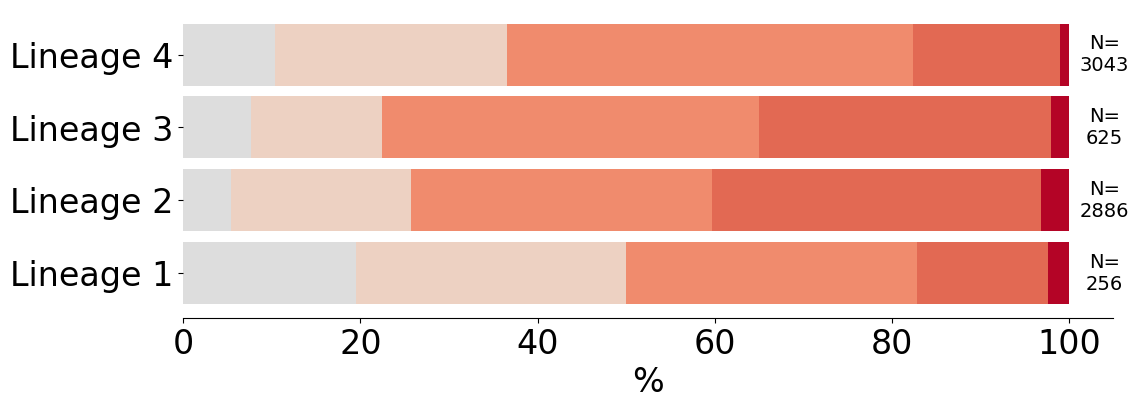

In [76]:
#make resistance phenotpye by lineage graphs

#remove lineages outside of the major 4 (L1,L2,L3,L4)
lin_counts_df=lin_counts_df.loc[(lin_counts_df['COUNTRY']!='Non-mtb')&(lin_counts_df['COUNTRY']!='Lineage 6')&(lin_counts_df['COUNTRY']!='TOTAL')]

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.figure(figsize=(12, len(lin_counts_df)))

N = len(lin_counts_df)

#calculate percentages of each phenotype in each lineage
P1 = (lin_counts_df['RANDI_S'].values/lin_counts_df['NO_R'].values*100)
P2 = (lin_counts_df['INH_R'].values/lin_counts_df['NO_R'].values*100)
P3 = ((lin_counts_df['MDR/RR'].values-lin_counts_df['PRE_XDR'].values-lin_counts_df['XDR'].values)/lin_counts_df['NO_R'].values*100)
P4 = (lin_counts_df['PRE_XDR'].values/lin_counts_df['NO_R'].values*100)
P5 = (lin_counts_df['XDR'].values/lin_counts_df['NO_R'].values*100)




ind = np.arange(N)    # the x locations for the groups
width = 0.85       

#plot stacked bars
p1 = plt.barh(ind, P1, width, color='#dddddd')
p2 = plt.barh(ind, P2, width, left=P1, color='#edd1c2')
p3 = plt.barh(ind, P3, width, left=P1+P2, color='#f08b6d')
p4 = plt.barh(ind, P4, width, left=P1+P2+P3, color='#e26953')
p5 = plt.barh(ind, P5, width, left=P1+P2+P3+P4, color='#b40426')


plt.xlabel('%')
plt.title('')
plt.yticks(ind, (['Lineage 1','Lineage 2','Lineage 3','Lineage 4']))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

for i in range(0,N):
    plt.text(104, i, 'N=\n'+str(lin_counts_df['NO_R'].values[i]), ha = 'center', va='center')


plt.savefig('lineage_R.png', dpi=300, transparent=True, bbox_inches='tight')




In [81]:
#make dataframe of percentage of a drug that is resistant to each of the others

drug_names_list=['INH','RIF', 'EMB', 'LEV','MXF','AMI', 'KAN','BDQ','CFZ','DLM','LZD', 'ETH', 'RFB']

#create copy of drug_df (resistance profile of each isolate to 13 drugs)
mdr_df=drugs_df
print(len(mdr_df))

#create dataframe of drug 1 name, drug 2 name, number os isolates resistant to both drugs and total samples with phenotpyes for both drugs
mdr_df2 = pd.DataFrame(columns=['drug1','drug2', 'instance', 'total'])
for i,j in (list(itertools.product(drug_names_list, repeat=2))):
    list2=[]
    list2.append(i)
    list2.append(j)
    list2.append(len(mdr_df[(mdr_df[i]==1)&(mdr_df[j]==1)]))
    i_mdr_df=mdr_df.loc[mdr_df[i]==1]
    list2.append(len(i_mdr_df)-len(i_mdr_df[(i_mdr_df[j].isna())]))
    df_length = len(mdr_df2)
    mdr_df2.loc[df_length] = list2

#create lists of lists for instances and totals by each drug
big_list=[]
t_list=[]
for i in drug_names_list:
    x=mdr_df2.loc[mdr_df2['drug1']==i].instance.to_list()
    big_list.append(x)
    t=mdr_df2.loc[mdr_df2['drug1']==i].total.to_list()
    t_list.append(t)
    
#create arrays and divide positive samples by totals
mdr_array=np.array(big_list)
t_array=np.array(t_list)
array_list=[]
for i in range(0,len(mdr_array)):
    array_list.append(mdr_array[i]/t_array[i])
prop_array=np.array(array_list)

#turn into percentages
percent_array=np.round(prop_array*100,1)

#turn array into dataframe indexed by drug
index = drug_names_list
columns = drug_names_list
df = pd.DataFrame(percent_array, index=index, columns=columns).astype('float')
print(df)

12289
       INH    RIF    EMB    LEV    MXF    AMI    KAN    BDQ    CFZ    DLM  \
INH  100.0   74.8   38.0   34.0   27.8   14.0   17.0    1.5    5.5    1.7   
RIF   93.5  100.0   46.3   41.4   34.1   17.2   20.8    1.8    6.0    1.7   
EMB   98.5   95.9  100.0   53.9   47.1   23.3   26.4    2.4    8.2    2.3   
LEV   93.3   90.2   56.9  100.0   78.5   27.3   31.3    3.1    9.4    2.9   
MXF   95.0   92.3   61.9   97.6  100.0   29.9   34.6    3.2    9.9    2.7   
AMI   93.0   90.4   58.9   65.3   57.8  100.0   90.4    2.4   13.0    5.2   
KAN   89.4   86.7   53.0   59.5   53.2   72.0  100.0    1.8   10.6    3.2   
BDQ   79.4   77.8   49.5   60.7   49.5   20.0   18.9  100.0   52.4   12.9   
CFZ   61.9   52.8   34.9   38.2   32.1   21.8   22.5   10.6  100.0    9.4   
DLM   55.2   44.4   28.2   33.2   23.9   24.4   19.1    7.1   26.3  100.0   
LZD   77.6   69.9   53.2   64.7   58.7   46.7   41.2    9.8   34.2   24.1   
ETH   96.5   79.4   47.0   48.7   41.9   21.1   26.2    2.2    8.3    

In [82]:
#difference between RIF+FRB resistance and RFB+RIF resistance
z_test(mdr_array[1,12],t_array[1,12],mdr_array[12,1],t_array[12,1])
#difference between LEV+MXF resistance and MXF+LEV resistance
z_test(mdr_array[3,4],t_array[3,4],mdr_array[4,3],t_array[4,3])
#difference between AMI+KAN resistance and KAN+AMI resistance
z_test(mdr_array[5,6],t_array[5,6],mdr_array[6,5],t_array[6,5])

z_stat: -11.07171, p_value: 0.00000
Reject the null hypothesis - suggest the alternative hypothesis is true
z_stat: -17.52641, p_value: 0.00000
Reject the null hypothesis - suggest the alternative hypothesis is true
z_stat: 10.22795, p_value: 0.00000
Reject the null hypothesis - suggest the alternative hypothesis is true


<ipython-input-89-240b730431df>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('heatmap_fig.png', dpi=300, tightlayout=True, transparent=True)


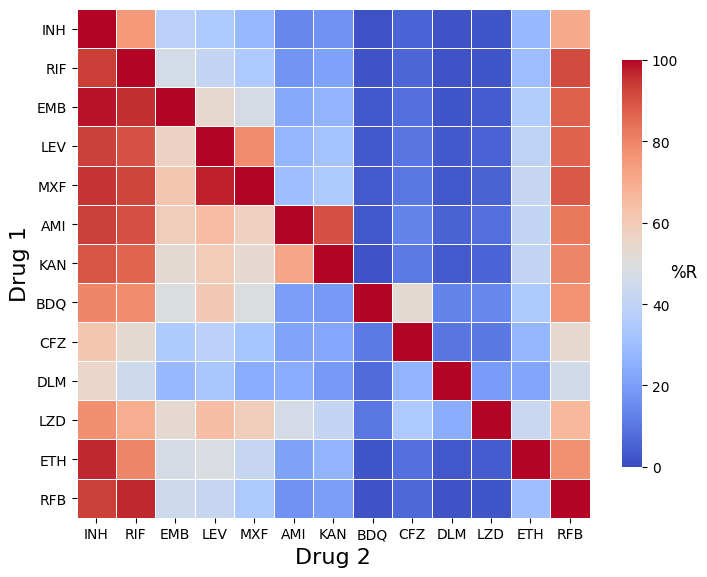

In [89]:
#make heatmap figure
plt.figure(figsize=(7.5, 6))
ax=sns.heatmap(df, cmap='coolwarm', linewidths=0.5, annot=False, fmt='d', annot_kws={"size":10},
               vmax=100,vmin=0,cbar=True, cbar_kws={'shrink':0.8})

plt.xticks(ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5], labels=drug_names_list)
plt.yticks(ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5], labels=drug_names_list)
ax.set_yticklabels(drug_names_list,rotation=0, size=10)
ax.set_xticklabels(drug_names_list,rotation=0, size=10)

cbar = ax.collections[0].colorbar
cbar.set_label('%R', rotation=0, size=12)
cbar.set_ticks([0, 20, 40, 60,80,100])
cbar.ax.tick_params(labelsize=10)
cbar.set_ticklabels(['0', '20', '40', '60','80','100'])
ax.set_ylabel('Drug 1', size=16)
ax.set_xlabel('Drug 2', size=16)

plt.tight_layout()
plt.savefig('heatmap_fig.png', dpi=300, tightlayout=True, transparent=True)

In [90]:
def make_other_drugs_graphs(fls_df, drugs_list, color, file_name):
    '''Given a subset of drugs_df (fls_df), function produces graph show proportion of isolates that have resistance to each drug 
    in drugs_list. Color is color of bars. FIlename is name of file to save graph as'''
    print(file_name)
    fls_other=[]
    fls_totals=[]
    for i in drugs_list:
        fls_other.append(len(fls_df.loc[fls_df[i]==1]))
        fls_totals.append(len(fls_df)-len(fls_df.loc[fls_df[i].isna()]))
    fls_list = [int(m) / int(t) for m,t in zip(fls_other, fls_totals)]
    fls_list
    print(fls_list)
    SMALL_SIZE = 16
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)         
    plt.rc('axes', titlesize=MEDIUM_SIZE)     
    plt.rc('axes', labelsize=MEDIUM_SIZE)    
    plt.rc('xtick', labelsize=SMALL_SIZE)   
    plt.rc('ytick', labelsize=SMALL_SIZE)    
    plt.rc('legend', fontsize=MEDIUM_SIZE)    
    plt.rc('figure', titlesize=BIGGER_SIZE)
    plt.figure(figsize=(len(fls_other)/2,4))
    N=len(fls_list)
    ind = np.arange(N)
    width=0.85
    plt.bar(ind,[i * 100 for i in fls_list], color=color)

    plt.ylabel('%')
    plt.ylim(0,100)
    plt.xticks(ind,other_drug_names,rotation=45)
    plt.text(len(fls_other)-4,95,"N="+str(len(fls_df)),)
    for pos in ['right', 'top']: 
        plt.gca().spines[pos].set_visible(False)
    plt.savefig(file_name, dpi=300, transparent=True, bbox_inches='tight')

MDR_other.png
[0.4632731958762887, 0.41397849462365593, 0.3406404470234258, 0.17177647314633615, 0.20804498269896193, 0.018248968064305888, 0.059743645448620465, 0.017397049108125964, 0.02304544475554598, 0.2935205183585313, 0.9129225502781344]
INHS+RIFS_other.png
[0.03838771593090211, 0.24084778420038536, 0.13653846153846153, 0.08863198458574181, 0.18146718146718147, 0.027079303675048357, 0.32947976878612717, 0.13733075435203096, 0.05566218809980806, 0.08253358925143954, 0.07364341085271318]
RIFR_other.png
[0.043333333333333335, 0.06397306397306397, 0.04713804713804714, 0.04745762711864407, 0.0707070707070707, 0.02348993288590604, 0.08108108108108109, 0.027874564459930314, 0.016722408026755852, 0.0547945205479452, 0.8504983388704319]
INHR_other.png
[0.0478502080443828, 0.05620287868403016, 0.03967168262653899, 0.023335621139327384, 0.03223593964334705, 0.006189821182943604, 0.047619047619047616, 0.017470300489168415, 0.010238907849829351, 0.2050929112181693, 0.06786703601108034]
XDR_o

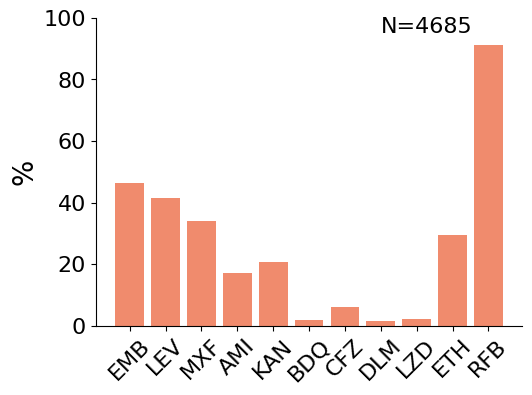

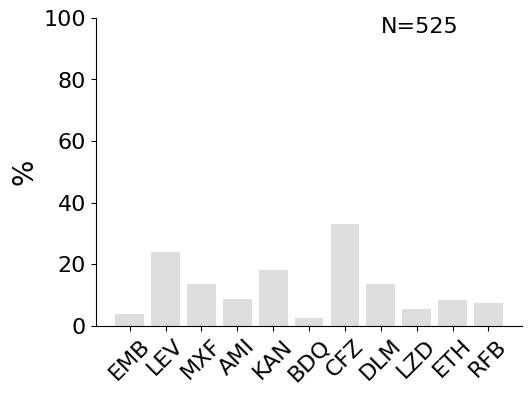

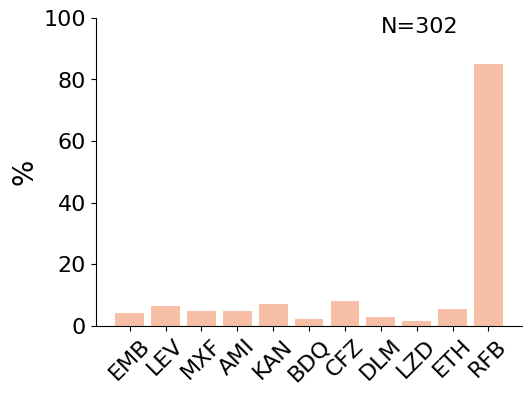

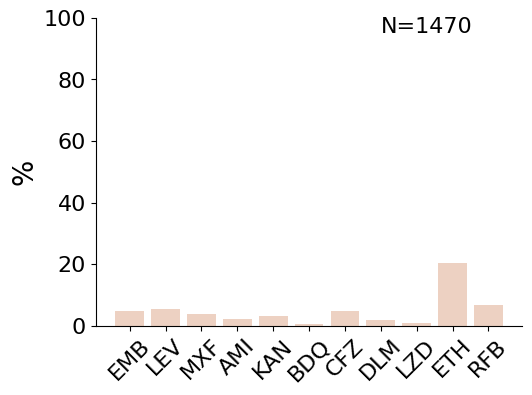

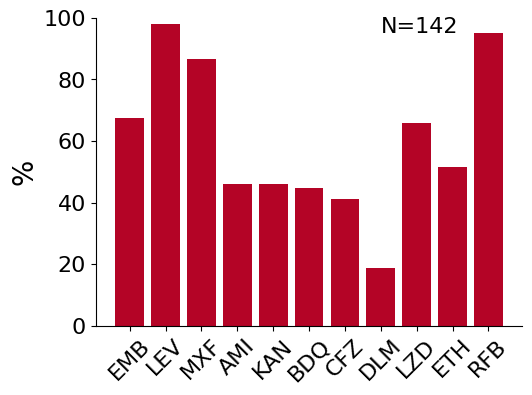

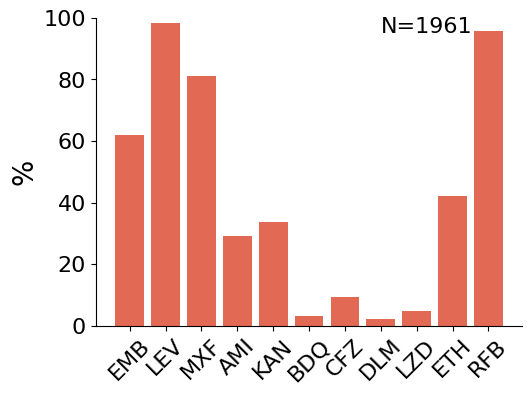

In [91]:
#make graphs showing additional resistance in different phenotypic backgrounds (INH S + RIF S, INH R + RIF S, MDR, XDR...)
other_drug_names=['EMB','LEV','MXF','AMI','KAN','BDQ','CFZ','DLM','LZD','ETH', 'RFB']
make_other_drugs_graphs(drugs_df.loc[(drugs_df.RIF)==1], other_drug_names, '#f08b6d', 'MDR_other.png')

make_other_drugs_graphs(drugs_df.loc[(drugs_df.RIF==0) & (drugs_df.INH==0) & (drugs_df.sum(axis=1)>=1)], 
                        other_drug_names, '#dddddd', 'INHS+RIFS_other.png')

make_other_drugs_graphs(drugs_df.loc[(drugs_df.RIF==1) & (drugs_df.INH==0) & (drugs_df.sum(axis=1)>=1)], 
                        other_drug_names, '#f6bfa6', 'RIFR_other.png')

make_other_drugs_graphs(drugs_df.loc[(drugs_df.RIF==0) & (drugs_df.INH==1) & (drugs_df.sum(axis=1)>=1)], 
                        other_drug_names, '#edd1c2', 'INHR_other.png')

make_other_drugs_graphs(drugs_df.loc[(drugs_df.RIF==1) & ((drugs_df.LEV==1) | (drugs_df.MXF==1)) & ((drugs_df.BDQ==1)|(drugs_df.LZD==1))], 
                        other_drug_names, '#b40426', 'XDR_other.png')

make_other_drugs_graphs(drugs_df.loc[(drugs_df.RIF==1) & ((drugs_df.LEV==1) | (drugs_df.MXF==1))], 
                        other_drug_names, '#e26953', 'PRE_XDR_other.png')